------------------------------------------------------------------------------------------------------------------------
### <b>Table of Content</b>

0. Background

1. Import functions

2. Load data

3. Explore data<br>
    3-1. Examine and transform data formats<br>
    3-2. Plot histograms and box plots<br>
    3-3. Plot a correlation heatmap<br>
    3-4. Plot seasonal decomposition<br>
    3-5. Plot autocorrelations

3. build a classification model to access the performance of cloned audio's target speaker<br>
    3-1. Convert .wav to machine-readable form<br>
    3-2. train a model<br>
    3-3. evaluate classification accuracy using test data

4. first, build a voice cloning system given a speaker’s spoken audio that clones the source speaker’s voice to the target speaker’s voice<br>
    4-1. For the voice cloning system (VC), you can utilize the TIMIT dataset as it consists of aligned text-audio data with various speakers.<br>
    4-2. Use Word Error Rate (WER) for automatic evaluation of the voice cloning (VC) system for the speech generation part<br>
    &emsp; 4-2-1. speech to text<br>
    &emsp; 4-2-2. measure WER using the original script and transcribed text<br>
    4-3. also report speaker classification accuracy to assess the performance of the generated audio’s target speaker.

5. Next, build a machine learning system which detects if any spoken audio is a natural speech or synthetically generated by machine.<br>
    5-1. For the fake audio detection system (FAD) you can utilize the CommonVoice dataset as it consists of thousands of naturally spoken audio which could be used as golden spoken audio by humans as positive examples and creating negative examples using the voice cloning system as automatic data/label generator.<br>
    => can sample files from 'validated.tsv' with most upvotes?
    5-2. For the fake audio detection (FAD) system evaluate the performance of the models using F-score via positive labels coming from the groundtruth dataset and negative labels generated by the VC.



4. Select and engineer features

5. Train models<br>
    5-1. Split data into train and test sets<br>
    5-2. SARIMAX model<br>
    &emsp; 5-2-1. Perform stepwise search<br>
    &emsp; 5-2-2. Train with best orders<br>
    5-3. Train and evaluate different models<br>
    &emsp; 5-3-1. Train three different models<br>
    &emsp; 5-3-2. Compare model performance

6. Evaluate prediction results<br>
    6-1. Create Bollinger Bands<br>
    6-2. Get trading dates with different intervals<br>
    6-3. Make training decisions and get capital returns<br>
    &emsp; 6-3-1. Based on SARIMAX predictions<br>
    &emsp; 6-3-2. Based on Bollinger Band

7. Build pipeline and process all stock data<br>
    7-1. Interpret results<br>
    &emsp; 7-1-1. Capital returns<br>
    &emsp; 7-1-2. Model performance

8. Conclusion
------------------------------------------------------------------------------------------------------------------------

### <b>0. Background</b>

This project is for a cyber security company providing products and services that can detect whether audio and video media is authentic or fake.

We are given two publically available corpora of speech data, which are the <a href="https://github.com/philipperemy/timit">TIMIT</a> and <a href="https://commonvoice.mozilla.org/en/datasets">CommonVoice</a> datasets. We will build two machine learning systems using these datasets as follows:

1. A voice cloning (VC) system that clones a given speaker's spoken audio to the target speaker's voice.
2. A fake audio detection (FAD) system that detects if any spoken audio is natural speech or synthetically generated by machines.

More details can be found in <a href="https://github.com/henryhyunwookim/K7h2vHrgG1Gl0S2r#readme">README</a>.

### <b>1. Import functions</b>

In [1055]:
from TTS.api import TTS

import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
from ordered_set import OrderedSet
import librosa
from librosa.display import waveshow
from IPython.display import Audio
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from utils.load import get_variables_for_voice_cloning, get_concat_audio
from utils.save import copy_original
from utils.evaluate import transcribe_audio_and_evaluate, hyperparameter_tuning_and_evaluation
from utils.process import process_audio, clone_voice
from utils.split import custom_train_test_split
from utils.transform import normalize_scale
from utils.plot import plot_callbacks_history

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

### <b>2. Load data</b>

Define file directories.

In [1056]:
root_dir = Path(sys.path[0])

timit_dir = root_dir / 'data' / 'TIMIT' / 'archive'
common_voice_dir = root_dir / 'data' / 'CommonVoice' / \
    'cv-corpus-14.0-delta-2023-06-23-en.tar' / \
    'cv-corpus-14.0-delta-2023-06-23-en' / \
    'cv-corpus-14.0-delta-2023-06-23' / 'en' / 'clips'

main_output_dir= root_dir / 'output'
if not os.path.exists(main_output_dir):
    os.mkdir(main_output_dir)

target_concat_dir = main_output_dir / 'concat'
if not os.path.exists(target_concat_dir):
    os.mkdir(target_concat_dir)

Load CSV files.

In [1057]:
train_csv = pd.read_csv(timit_dir / 'train_data.csv', index_col='index').dropna(how='all').reset_index(drop=True)
train_csv.index = train_csv.index.astype(int).astype(str)

test_csv = pd.read_csv(timit_dir / 'test_data.csv', index_col='index').dropna(how='any').reset_index(drop=True)
test_csv.index = test_csv.index.astype(int).astype(str)

train_csv.head()

,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,TRAIN,DR4,MMDM0,SI681.WAV.wav,TRAIN/DR4/MMDM0/SI681.WAV.wav,TRAIN\\DR4\\MMDM0\\SI681.WAV.wav,True,True,False,False,False
1,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False


Audio and text files will be loaded based on the paths provided in the CSV files at a later step.

### <b>3. Explore data</b>

#### <b>3-1. Explore CSV files</b>

In [1058]:
train_unique_speakers = OrderedSet(train_csv.speaker_id)
test_unique_speakers = OrderedSet(test_csv.speaker_id)
print(f'Number of speakers in train_csv: {len(train_unique_speakers)}')
print(f'Number of speakers in test_csv: {len(test_unique_speakers)}')
print(f'Speakers that are found in both train_csv and test_csv: {train_unique_speakers & test_unique_speakers}')

Number of speakers in train_csv: 462
Number of speakers in test_csv: 168
Speakers that are found in both train_csv and test_csv: OrderedSet()


As shown above, there's no overlap between speakers in the train and test sets. This means that any predictive model will not be able to predict the correct speakers when it was trained with the train data and then was fed the test data for making predictions since the speakers in the test data had never been seen during the training process.

For this reason, 'train_csv' and 'test_csv' will be combined and then later split into train and test sets, in such a way that the model can be trained with a more variety of different speakers.

Additionally, as shown below, every speaker in both the train and test data provided 10 audio files.

In [1059]:
train_num_wav_per_speaker = train_csv[train_csv['filename'].str.contains('WAV.wav')].value_counts('speaker_id').unique()
test_num_wav_per_speaker = test_csv[test_csv['filename'].str.contains('WAV.wav')].value_counts('speaker_id').unique()
print(f'Numbers of wav files for a single speaker in train_csv: {train_num_wav_per_speaker}')
print(f'Numbers of wav files for a single speaker in test_csv: {test_num_wav_per_speaker}')

Numbers of wav files for a single speaker in train_csv: [10]
Numbers of wav files for a single speaker in test_csv: [10]


Merge test_csv into train_csv for the aforementioned reasons.

In [1060]:
merged_csv = pd.concat([train_csv, test_csv]).reset_index(drop=True)

how to improve the quality of voice cloning and evaluation?
- for target audio, concat all available audio files by the target speaker, instead of using a single audio file that is only about 2-3 second long; the concatenated target audio file would be about 20-30 seconds.
- for training a model, only feed audio data from a small number of speakers. This is to improve the probability of correctly predicting the speaker ID (or label) - if the number of labels is only 10, correctly predicting the label would be 1/10, while it would be 1/400+ if we use all audio files for training a model and try to predict the correct label out of 400+.
- evaluate 19-20 different voice cloning models and only use the best performing models for voice cloning.

In [1061]:
merged_csv['gender'] = merged_csv['speaker_id'].apply(lambda x: 'male' if x[0] == 'M' else 'female')

In [1062]:
save_dir = root_dir / 'saved'
stratified_sample_df_path = f'{save_dir}/stratified_sample_df.csv'
num_sample_per_gender = 2

if os.path.exists(stratified_sample_df_path):
    stratified_sample_df = pd.read_csv(stratified_sample_df_path)
    print('stratified_sample_df loaded from CSV.')
else:
    stratified_sample_speakers = merged_csv.groupby('gender')['speaker_id'].apply(
        lambda x: x.sample(num_sample_per_gender)).reset_index(drop=True).values
    stratified_sample_df = merged_csv[ merged_csv['speaker_id'].apply(lambda x: x in stratified_sample_speakers) ]
    stratified_sample_df.to_csv(stratified_sample_df_path, index=False)
    print('stratified_sample_df saved as CSV.')

stratified_sample_df saved as CSV.


In [1063]:
unique_categories = set(stratified_sample_df['speaker_id'])
num_categories = len(unique_categories)
print(f'Number of unique speakers/categories in merged_csv: {num_categories}')

Number of unique speakers/categories in merged_csv: 4


Define mapping dictionaries for encoding (and decoding) the speaker IDs from string to integer so that machine learning models can understand the labels (i.e., categories or speaker IDs).

In [1064]:
speaker_id_dict = {speaker_id: i for i, speaker_id in enumerate(unique_categories)}
reverse_speaker_id_dict = {v: k for k, v in speaker_id_dict.items()}

#### <b>3-3. Explore audio data</b>

Get paths to audio files that are in 'wav' form.

In [1065]:
audio_path = stratified_sample_df[stratified_sample_df['is_converted_audio']==True]['path_from_data_dir'].drop_duplicates().reset_index(drop=True)
audio_path

0      TRAIN/DR3/MKXL0/SX285.WAV.wav
1       TRAIN/DR3/MKXL0/SX15.WAV.wav
2      TRAIN/DR3/MKXL0/SX105.WAV.wav
3     TRAIN/DR3/MKXL0/SI1958.WAV.wav
4        TRAIN/DR3/MKXL0/SA1.WAV.wav
5      TRAIN/DR3/MKXL0/SX375.WAV.wav
6     TRAIN/DR3/MKXL0/SI1815.WAV.wav
7     TRAIN/DR3/MKXL0/SI1185.WAV.wav
8        TRAIN/DR3/MKXL0/SA2.WAV.wav
9      TRAIN/DR3/MKXL0/SX195.WAV.wav
10      TRAIN/DR2/MRMS0/SX30.WAV.wav
11     TRAIN/DR2/MRMS0/SX120.WAV.wav
12     TRAIN/DR2/MRMS0/SX300.WAV.wav
13    TRAIN/DR2/MRMS0/SI2100.WAV.wav
14     TRAIN/DR2/MRMS0/SX210.WAV.wav
15    TRAIN/DR2/MRMS0/SI2057.WAV.wav
16     TRAIN/DR2/MRMS0/SX390.WAV.wav
17       TRAIN/DR2/MRMS0/SA1.WAV.wav
18    TRAIN/DR2/MRMS0/SI1113.WAV.wav
19       TRAIN/DR2/MRMS0/SA2.WAV.wav
20    TRAIN/DR2/FLMA0/SI1873.WAV.wav
21      TRAIN/DR2/FLMA0/SX73.WAV.wav
22     TRAIN/DR2/FLMA0/SX163.WAV.wav
23     TRAIN/DR2/FLMA0/SX343.WAV.wav
24     TRAIN/DR2/FLMA0/SX433.WAV.wav
25       TRAIN/DR2/FLMA0/SA1.WAV.wav
26     TRAIN/DR2/FLMA0/SI613.WAV.wav
2

There are 6300 audio files, where 630 different speakers provided 10 different audio files as we've learned from the earlier step.

Now, get an example audio path for exploration.

In [1066]:
example_audio_path = timit_dir / 'data' / audio_path[0]
example_audio_path

WindowsPath('d:/OneDrive/GitHub/Apziva/K7h2vHrgG1Gl0S2r/data/TIMIT/archive/data/TRAIN/DR3/MKXL0/SX285.WAV.wav')

Play the example auido after loading it as an array.

In [1067]:
audio_array, sample_rate = \
    librosa.load(example_audio_path, sr=None) # sr: sampling rate, or samples per second. default 22050.
Audio(data=audio_array, rate=sample_rate)

Visualize the audio array as a waveform in the time domain, where the y axis represents amplitude.

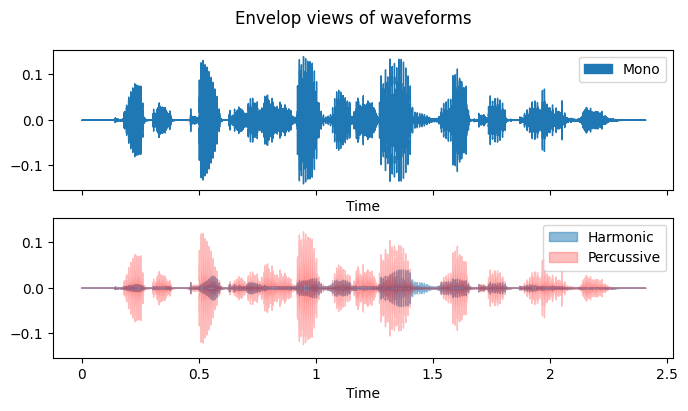

In [1068]:
# %matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=True)

waveshow(audio_array, sr=sample_rate, label='Mono', ax=ax[0])
ax[0].legend()

y_harm, y_perc = librosa.effects.hpss(audio_array)
librosa.display.waveshow(y_harm, sr=sample_rate, alpha=0.5, label='Harmonic', ax=ax[1])
librosa.display.waveshow(y_perc, sr=sample_rate, color='r', alpha=0.25, label='Percussive', ax=ax[1])
ax[1].legend()

plt.suptitle('Envelop views of waveforms');

Define variables for source and target audio files for cloning.

3. clone audio file

Copy original source and target files to the destination folder for an easier review of the output file.

In [1119]:
%%capture captured

n = 30
eval_df_list = []
for i in tqdm(range(n)):
    sampled = audio_path.sample(n=2, replace=False)
    source_audio_subpath = sampled.iloc[0]
    target_audio_subpath = sampled.iloc[1]
    # source_audio_subpath = source_list[i]
    # target_audio_subpath = target_list[i]

    source_speaker_id, source_audio_file, source_file_id, source_audio_path,\
    target_speaker_id, target_audio_file, target_file_id, target_audio_path,\
    source_text_file, source_text_path, source_text, output_dir, output_filename\
        = get_variables_for_voice_cloning(
            source_audio_subpath, target_audio_subpath, root_dir, timit_dir, stratified_sample_df)
    print()

    copy_original(output_dir, source_audio_file, source_audio_path,
                target_audio_file, target_audio_path, source_text_file, source_text_path)
    print()

    # Create a target audio file to reference,
    # which is a concatenation of 10 different audio files from the same target speaker.
    # This is to improve the quality of cloned audio.
    concat_target_audio_path = get_concat_audio(target_audio_path, target_concat_dir, target_speaker_id,
                                                add_silent=0, n_duplicate_concat=1)
    print()

    clone_voice(str(concat_target_audio_path),
                str(source_audio_path),
                source_text,
                output_dir, output_filename,
                tools=['voice_cloning', 'en_tts'], # 'voice_cloning', 'multilingual_tts', 
                en_tts_models=['vits'], # tacotron2-DDC_ph', 'vits', 'fast_pitch', 'tacotron2-DDC', 'vits--neon', 'jenny'
                noise_reduction=True, adjust_decibel=0, progress_bar=False, gpu=True
                )

    # Create a dictionary for evaluating the quality of transcriptions of the cloned audio files.
    eval_dict = transcribe_audio_and_evaluate(output_dir, output_filename, source_text)
    eval_df = pd.DataFrame(eval_dict).T
    eval_df_list.append(eval_df)
    # concat_eval_df = pd.concat([concat_eval_df, eval_df])
    # The following measures are implemented:
    # 1. Word Error Rate (WER), which is where this library got its name from. This
    #   has long been (and arguably still is) the de facto standard for computing
    #   ASR performance. - the lower the better (i.e. more accurate)
    # 2. Match Error Rate (MER) - the lower the better (i.e. more accurate)
    # 3. Word Information Lost (WIL) - the lower the better (i.e. more accurate)
    # 4. Word Information Preserved (WIP) - the larget the better
    # 5. Character Error Rate (CER) - the lower the better (i.e. more accurate)

# captured()

In [1120]:
concat_eval_df = pd.concat(eval_df_list)
eval_cols = ['wer', 'mer', 'wil', 'wip', 'cer']
concat_eval_df = concat_eval_df.sort_values(eval_cols, ascending=[True, True, True, False, True])
concat_eval_df.reset_index(drop=True)
concat_eval_df['model'] = concat_eval_df.index
concat_eval_df.head()

,wer,mer,wil,wip,cer,Transcription,Source Text,model
tacotron2-DDC,0.0,0.0,0.0,1.0,0.0,they remained lifelong friends and companions,they remained lifelong friends and companions,tacotron2-DDC
vc,0.0,0.0,0.0,1.0,0.0,they remained lifelong friends and companions,they remained lifelong friends and companions,vc
vits--neon,0.0,0.0,0.0,1.0,0.0,they remained lifelong friends and companions,they remained lifelong friends and companions,vits--neon
vits,0.0,0.0,0.0,1.0,0.0,they remained lifelong friends and companions,they remained lifelong friends and companions,vits
fast_pitch,0.0,0.0,0.0,1.0,0.0,aluminum silverware can often be flimsy,aluminum silverware can often be flimsy,fast_pitch


In [1121]:
concat_eval_path = f'{save_dir}/concat_eval_df.csv'

if os.path.exists(concat_eval_path):
    concat_eval_df = pd.read_csv(concat_eval_path)
    print('concat_eval_df loaded from CSV.')
else:
    concat_eval_df.to_csv(concat_eval_path, index=False)
    print('concat_eval_df saved as CSV.')

concat_eval_df.groupby('model').mean().sort_values(eval_cols, ascending=[True, True, True, False, True])

concat_eval_df loaded from CSV.


,wer,mer,wil,wip,cer
model,,,,,
jenny,0.066667,0.066667,0.111111,0.888889,0.021053
vits,0.083333,0.083333,0.148611,0.851389,0.016978
vits--neon,0.133333,0.133333,0.236111,0.763889,0.042784
tacotron2-DDC_ph,0.183333,0.183333,0.281944,0.718056,0.055688
fast_pitch,0.216667,0.166667,0.236111,0.763889,0.092020
tacotron2-DDC,0.250000,0.180000,0.235000,0.765000,0.090323
vc,0.700000,0.633333,0.685000,0.315000,0.586927


Available voice cloning models:
['vits', 'tacotron2-DDC_ph', 'vits--neon', 'tacotron-DDC', 'fast_pitch', 'multi',
'jenny', 'overflow', 'glow-tts', 'capacitron-t2-c150_v2', 'tacotron2-DCA',
'capacitron-t2-c50', 'tacotron2', 'vc', 'speedy-speech', 'neural_hmm']

Based on various statistics such as mean, std, max, etc., the 'vits' and 'tacotron2-DDC_ph' models performed the best in terms of the quality of the transcriptions of the synthesized auido data. The top 6 models were as follows:
['tacotron2-DDC_ph', 'vits', 'fast_pitch', 'tacotron2-DDC', 'vits--neon', 'jenny']

For predictions by the classification model, no particular model produced synthesized audio data that were correctly predicted as the target speaker a lot more than the others. Thus, choose the voice cloning models based on the quality of the transcriptions. => vc model often performs better than the rest, although the quality of transcription is not great.

In [1122]:
# vc_eval_df = pd.read_excel(save_dir / 'Book1.xlsx')
# vc_eval_df.set_index('model_name').mean(axis=1).sort_values(ascending=False)

## to be removed?:

However, based on the correct predictions by the classification model, the synthesized audio files by different voice cloning models resulted in more accuracte predictions. Here's the full table of each voice cloning model and the proportion of the correct predictions to all correct predictions; e.g., The 'vc' model produced the most audio files that were correctly classified as the target speakers, accounting for 13.6% of all correct predictions. To put it differently, there would be about 13.6 files (produced by the 'vc' model) out of 100 cloned files that were correctly classified by the classification model.

Based on the analysis above, it would be reasonable to only use the 'vits' model for voice cloning and the rest of the processes.

3-1. speech to text using the output file

# build an audio classification model to predict the speaker based on synthesized audio file

* MFCCs – The MFCC summarizes the frequency distribution across the window size. So, it is possible to analyze both the frequency and time characteristics of the sound. This audio representation will allow us to identify features for classification. So, it will try to convert audio into some kind of features based on time and frequency characteristics that will help us to do classification.

In [1268]:
n_mfcc = 40 # 40
train_size = 0.7 # 0.7

new_train_X_path = f'{save_dir}/new_train_X.csv'
new_test_X_path = f'{save_dir}/new_test_X.csv'
new_train_y_path = f'{save_dir}/new_train_y.csv'
new_test_y_path = f'{save_dir}/new_test_y.csv'

if os.path.exists(new_train_X_path) and\
     os.path.exists(new_test_X_path) and\
     os.path.exists(new_train_y_path) and\
     os.path.exists(new_test_y_path):

     # Load CSV files to data frames
     new_train_X = pd.read_csv(new_train_X_path)
     new_test_X = pd.read_csv(new_test_X_path)
     new_train_y = pd.read_csv(new_train_y_path)['label']
     new_test_y = pd.read_csv(new_test_y_path)['label']
     print('CSV files loaded as data frames.')

else:
     # Process audio files to get train_df
     train_X, train_y, train_df = process_audio(audio_path, timit_dir, n_mfcc=n_mfcc)

     # Split train_df into train and test sets
     new_train_df, new_train_X, new_train_y, new_test_df, new_test_X, new_test_y\
          = custom_train_test_split(train_df, train_size=train_size)

     # Save data frames to CSV files
     new_train_X.to_csv(new_train_X_path, index=False)
     new_test_X.to_csv(new_test_X_path, index=False)
     new_train_y.to_csv(new_train_y_path, index=False)
     new_test_y.to_csv(new_test_y_path, index=False)
     print('Data frames saved as CSV files.')

100%|██████████| 40/40 [00:00<00:00, 42.94it/s]

Data frames saved as CSV files.


In [1269]:
input_shape = (new_train_X.shape[1],)

# normalized_train_X, normalized_test_X = new_train_X, new_test_X
normalized_train_X, normalized_test_X, scaler = normalize_scale(new_train_X, new_test_X, method="standard")
# normalized_train_X, normalized_test_X, scaler = normalize_scale(new_train_X, new_test_X, method="minmax")

# label_encoder = LabelEncoder()
# train_y_cat = to_categorical(label_encoder.fit_transform(np.ravel(new_train_y)))
# test_y_cat = to_categorical(label_encoder.transform(np.ravel(new_test_y)))

# Manually encode without using LabelEncoder
encoded_train_y = new_train_y.map(speaker_id_dict)
encoded_test_y = new_test_y.map(speaker_id_dict)

sparse_train_y = np.zeros((encoded_train_y.shape[0], num_categories))
np.put_along_axis(arr=sparse_train_y, indices=encoded_train_y.values.reshape(-1,1), values=1, axis=1)

sparse_test_y = np.zeros((encoded_test_y.shape[0], num_categories))
np.put_along_axis(arr=sparse_test_y, indices=encoded_test_y.values.reshape(-1,1), values=1, axis=1)

The choice of optimizer in Keras for a multiclass classification problem depends on the architecture of your model, the nature of your dataset, and experimentation. Here are some commonly used optimizers that you can consider for multiclass classification:

1. **Adam (Adaptive Moment Estimation):**
   Adam is a popular and versatile optimizer that combines the benefits of both RMSProp and AdaGrad. It adapts the learning rate for each parameter, providing good convergence properties and fast training. It's often a good starting point due to its effectiveness in various scenarios.

   ```python
   optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
   ```
   What is the best learning rate for Adam optimizer?
      between 0.0001 and 0.01
      An optimal learning rate value (default value 0.001) means that the optimizer would update the parameters just right to reach the local minima. Varying learning rate between 0.0001 and 0.01 is considered optimal in most of the cases.

2. **RMSProp (Root Mean Square Propagation):**
   RMSProp adjusts the learning rate for each parameter based on the moving average of squared gradients. It's effective in handling sparse data and dealing with issues like vanishing and exploding gradients.

   ```python
   optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
   ```

3. **SGD (Stochastic Gradient Descent):**
   While basic, SGD can still be effective with careful tuning of the learning rate and momentum. However, it might require more manual adjustments compared to adaptive optimizers.

   ```python
   optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
   ```

4. **Adadelta:**
   Adadelta is another adaptive optimizer that adjusts the learning rate and accumulates past gradients. It's particularly useful when there's no clear initial learning rate choice.

   ```python
   optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
   ```

5. **Nadam:**
   Nadam combines the benefits of Nesterov accelerated gradient (NAG) and Adam. It's similar to Adam but uses NAG for gradient updates. It's often effective in practice.

   ```python
   optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002)
   ```

It's important to note that the performance of optimizers can vary based on the specific problem and dataset. Experiment with multiple optimizers and different learning rates to find the best one for your model. Also, consider adjusting the learning rate during training using learning rate schedulers to achieve better convergence and performance.

In [1270]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

# # https://xgboost.readthedocs.io/en/stable/parameter.html
# params = {
#     'booster': ['gbtree', 'gblinear', 'dart'],
#     'learning_rate': np.arange(0, 1, 0.05),
#     'gamma': np.arange(0, 10, 0.5),
#     'max_depth': np.arange(1, 6, 1),
#     'n_estimators': np.arange(50, 500, 50)
# }

# # try hyperparameter tuning via randomized search using original X (without normalization)
# best_search = hyperparameter_tuning_and_evaluation(
#     classifier=XGBClassifier(), eval_metric='accuracy',
#     n_iter=1, cv=2, random_state=6,
#     X_train=new_train_X, y_train=encoded_train_y,
#     X_test=new_test_X, y_test=encoded_test_y,
#     params=params
# )
# best_model = best_search.best_estimator_
# accuracy_score(best_model.predict(new_test_X), encoded_test_y)
# # accuracy_score: 0.9018759018759018
# # n_iter: 1, cv: 2, best_score: 0.81, test_score: 0.9

# # XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
# #               colsample_bylevel=None, colsample_bynode=None,
# #               colsample_bytree=None, early_stopping_rounds=None,
# #               enable_categorical=False, eval_metric=None, feature_types=None,
# #               gamma=7.5, gpu_id=None, grow_policy=None, importance_type=None,
# #               interaction_constraints=None, learning_rate=0.1, max_bin=None,
# #               max_cat_threshold=None, max_cat_to_onehot=None,
# #               max_delta_step=None, max_depth=5, max_leaves=None,
# #               min_child_weight=None, missing=nan, monotone_constraints=None,
# #               n_estimators=50, n_jobs=None, num_parallel_tree=None,
# #               objective='multi:softprob', predictor=None, ...)

In [1305]:
from utils.statistics import f1_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

dropout_rate = 0.75 # 0.75
learning_rate = 0.008 # 0.008

model=Sequential()

# first layer
model.add(Dense(1024, activation='relu', input_shape=input_shape)) # 1024
model.add(Dropout(dropout_rate)) 

# second layer
model.add(Dense(1024, activation='relu')) # 1024
model.add(Dropout(dropout_rate))

# final layer
model.add(Dense(num_categories, activation='softmax'))

model.compile(
    optimizer=Adam(lr=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']) # Predicting the correct class is the primary concern in our case, 
                          # thus use 'accuracy' as the performance metric.

model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 1024)              41984     
                                                                 
 dropout_112 (Dropout)       (None, 1024)              0         
                                                                 
 dense_169 (Dense)           (None, 1024)              1049600   
                                                                 
 dropout_113 (Dropout)       (None, 1024)              0         
                                                                 
 dense_170 (Dense)           (None, 4)                 4100      
                                                                 
Total params: 1,095,684
Trainable params: 1,095,684
Non-trainable params: 0
_________________________________________________________________


In [1306]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
import pickle
import json
from tensorflow.keras.models import load_model
import numpy as np

best_model_path = f'{save_dir}/audio_classification.h5'
best_result_path = f'{save_dir}/audio_classification.json'
# scaler_path = f'{save_dir}/scaler.pkl'
# label_encoder_path = f'{save_dir}/label_encoder.pkl'
val_dict_path = f'{save_dir}/val_dict.json'
# checkpoint_path = f'{save_dir}/audio_classification.hdf5'

# if os.path.exists(best_result_path):
#         print('Load saved model with scaler, label encoder and results from drive.')
#         model = load_model(best_model_path)
#         # scaler = pickle.load(open(scaler_path, 'rb'))
#         # label_encoder = pickle.load(open(label_encoder_path, 'rb'))
#         history = json.load(open(best_result_path, 'r'))
#         # val_dict = {int(k): v for k, v in json.load(open(val_dict_path, 'r')).items()}
#         val_dict = json.load(open(val_dict_path, 'r'))

# else:
num_epochs = 10 # 100
num_batch_size = 4 # 64

# checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=2, save_best_only=True)

start = datetime.now()

history = model.fit(
        normalized_train_X,
        # new_train_X,
        sparse_train_y,
        batch_size=num_batch_size,
        epochs=num_epochs,
        validation_data=(normalized_test_X, sparse_test_y),
        # validation_data=(new_test_X, sparse_test_y),
        # callbacks=[checkpointer],
        verbose=2
        )
# By default verbose = 1,
# verbose = 1, which includes both progress bar and one line per epoch
# verbose = 0, means silent
# verbose = 2, one line per epoch i.e. epoch no./total no. of epochs

duration = datetime.now() - start
print(f'\nTraining completed in {duration}.')

# Convert the tf.keras.callbacks.History object into a dictionary, if not loaded from local drive.
if not isinstance(history, dict):
        history = {**history.params, 'epoch': history.epoch, **history.history}

print('\nCreating a dictionary for validation scores.')
val_dict = {}
label_list = new_test_y.drop_duplicates().values
idx_list = np.arange(0, normalized_test_X.shape[0], 3)
for label, idx in zip(label_list, idx_list):
        val_X = normalized_test_X[idx : idx+3]
        val_y = sparse_test_y[idx : idx+3]
        val_loss, val_accuracy = model.evaluate(val_X, val_y, verbose=0)
        val_dict[label] = {'val_loss': val_loss, 'val_accuracy': val_accuracy}

Epoch 1/10


6/6 - 2s - loss: 1.5371 - accuracy: 0.4583 - val_loss: 1.2377 - val_accuracy: 0.5625 - 2s/epoch - 343ms/step
Epoch 2/10
6/6 - 0s - loss: 1.9008 - accuracy: 0.2500 - val_loss: 1.0461 - val_accuracy: 0.9375 - 188ms/epoch - 31ms/step
Epoch 3/10
6/6 - 0s - loss: 1.8005 - accuracy: 0.3333 - val_loss: 0.8616 - val_accuracy: 0.9375 - 187ms/epoch - 31ms/step
Epoch 4/10
6/6 - 0s - loss: 1.2596 - accuracy: 0.4167 - val_loss: 0.6945 - val_accuracy: 0.9375 - 280ms/epoch - 47ms/step
Epoch 5/10
6/6 - 0s - loss: 1.1357 - accuracy: 0.4583 - val_loss: 0.5315 - val_accuracy: 1.0000 - 234ms/epoch - 39ms/step
Epoch 6/10
6/6 - 0s - loss: 0.6651 - accuracy: 0.6667 - val_loss: 0.4210 - val_accuracy: 1.0000 - 261ms/epoch - 44ms/step
Epoch 7/10
6/6 - 0s - loss: 0.8920 - accuracy: 0.7083 - val_loss: 0.3295 - val_accuracy: 1.0000 - 317ms/epoch - 53ms/step
Epoch 8/10
6/6 - 0s - loss: 0.5216 - accuracy: 0.8333 - val_loss: 0.2547 - val_accuracy: 1.0000 - 336ms/epoch - 56ms/step
Epoch 9/10
6/6 - 0s - loss: 0.4127 - 

In [1307]:
# best_model.predict()

In [1308]:
# Evaluate the model
test_loss, test_acc = model.evaluate(normalized_test_X, sparse_test_y)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

for k, v in history.items():
    best_score = None
    if 'loss' in k:
        best_score = min(v)
    elif 'accuracy' in k:
        best_score = max(v)

    if best_score != None:
        print(f'Best {k}: {round(best_score, 4)}')

1/1 [==============================] - 0s 59ms/step - loss: 0.1685 - accuracy: 1.0000
Test loss: 0.16854096949100494
Test accuracy: 1.0
Best loss: 0.3803
Best accuracy: 0.875
Best val_loss: 0.1685
Best val_accuracy: 1.0


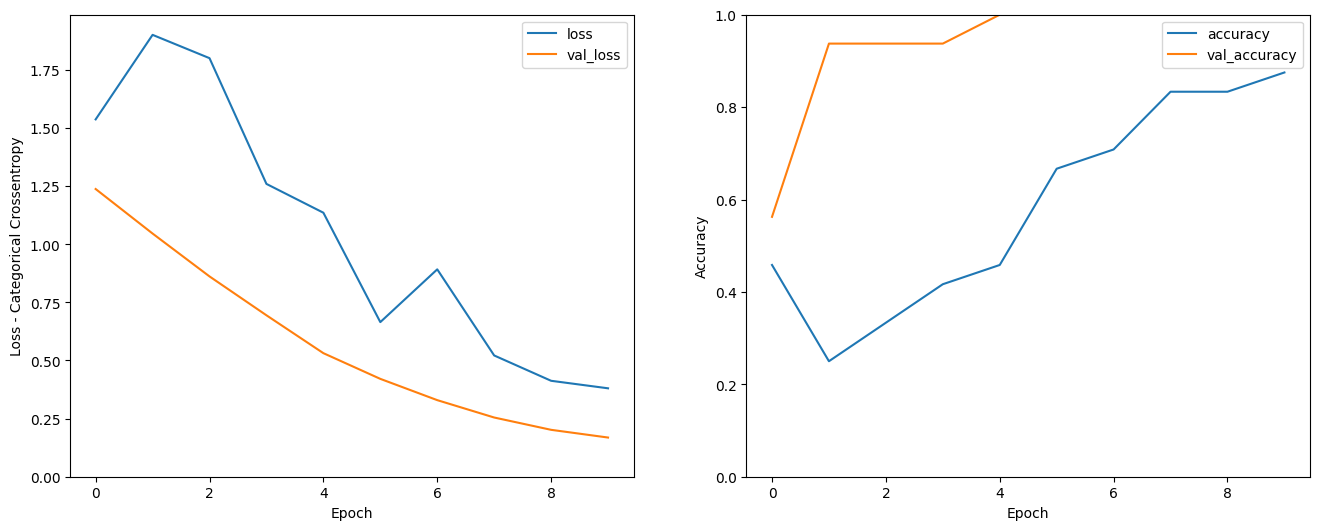

In [1309]:
%matplotlib inline
plot_callbacks_history(history, figsize=(16, 6), eval_metrics=['Categorical Crossentropy', 'Accuracy'])

In [1310]:
val_df = pd.DataFrame(val_dict).T
val_df = val_df.sort_values(['val_accuracy', 'val_loss'], ascending =[False, True])
val_df

,val_loss,val_accuracy
FTLH0,0.048938,1.0
FLMA0,0.058908,1.0
MRMS0,0.135732,1.0
MKXL0,0.222355,1.0


In [1311]:
# Saving the model and other objects

# model.save(best_model_path)
# # pickle.dump(scaler, open(scaler_path, 'wb'))
# # pickle.dump(label_encoder, open(label_encoder_path, 'wb'))
# json.dump(history, open(best_result_path, 'w'))
# json.dump(val_dict, open(val_dict_path, 'w'))

Considering we only have 10 audio files for both training and validation, an accuracy score over 90% is very good.

Moving on to verifying whether cloned audio files are correctly classified as the original speaker.

In [1314]:
# Iterate through all cloned audio files
import librosa
from sklearn.preprocessing import StandardScaler

X_list = []
y_list = []
wav_path_list = []
for folder in os.listdir(root_dir / 'output'):
    for file in os.listdir(root_dir / 'output' / folder):
        if '_to_' in file:
            # if 'vc_' in file: # Only include files generated by speech_generator from voice_cloning library
            wav_path = root_dir / 'output' / folder / file
            wav_path_list.append(wav_path)
            
            label = file.split('_to_')[1].split('-')[0]
            y_list.append(label)

            audio_array, sample_rate = librosa.load(wav_path, sr=None)
            # print(f'Shape of audio array: {audio_array.shape}')
            mfccs_features = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc=n_mfcc)
            # print(f'Shape of mfccs features: {mfccs_features.shape}')
            normalized_mfccs_features = np.mean(mfccs_features.T, axis=0)
            # print(f'Shape of scaled mfccs features: {normalized_mfccs_features.shape}')
            X_list.append(normalized_mfccs_features)

            # scaled_X = StandardScaler().fit_transform(normalized_mfccs_features.reshape(-1, 1)).reshape(1, -1)[0]
            # X_list.append(scaled_X)

df = pd.DataFrame(X_list)
df['label'] = y_list

X = df.drop(['label'], axis=1)
y = df[['label']]

In [1315]:
# normalized_X = X
normalized_X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# from sklearn.preprocessing import StandardScaler
# test_scaler = StandardScaler()
# test_scaler.fit_transform(new_train_X)
# normalized_X = pd.DataFrame(test_scaler.transform(X),
#                         index=X.index, columns=X.columns)
                        
# normalized_X = ((X - np.mean(X, axis=0)) / np.std(X, axis=0))

encoded_y = y['label'].map(speaker_id_dict)
sparse_y = np.zeros((encoded_y.shape[0], num_categories))
np.put_along_axis(arr=sparse_y, indices=encoded_y.values.reshape(-1,1), values=1, axis=1)

# model.evaluate(normalized_X, sparse_y)
model.evaluate(normalized_X, sparse_y)
# for label, encoded in zip(y.values, encoded_y):
#     print(f'True label: {label} ({encoded})')
# print(f'True label: {y.values} ({encoded_y.values})')

3/3 [==============================] - 0s 8ms/step - loss: 1.9855 - accuracy: 0.3286


[1.9855281114578247, 0.3285714387893677]

In [1316]:
# accuracy_score(encoded_y, best_search.best_estimator_.predict(normalized_X))

In [1317]:
code_pred = np.argmax(model.predict(normalized_X), axis=1)
# code_pred

3/3 [==============================] - 0s 7ms/step


In [1318]:
pred_prob = np.max(model.predict(normalized_X), axis=1)
# pred_prob
# np.max(model.predict(X), axis=1)
# Some of the predictions have low probabilities, e.g., below 0.5.

3/3 [==============================] - 0s 6ms/step


In [1319]:
wav_dict_list = []
for wav_path in wav_path_list:
    substr = str(wav_path).split('output')[1].split('\\')[2]
    if '_M' in substr.split('_to_')[0]:
        model_name = substr.split('_to_')[0].split('_M')[0]
    else:
        model_name = substr.split('_to_')[0].split('_F')[0]
    subsubstr = substr.split(model_name+'_')[1].replace('.wav', '')
    source, target = subsubstr.split('_to_')
    source_speaker, source_script = source.split('-')
    target_speaker, target_script = target.split('-')
    wav_dict = {
        'model_name': model_name,
        'source_speaker': source_speaker,
        'source_script': source_script,
        'target_speaker': target_speaker,
        'target_script': target_script,
        'wav_path': wav_path
    }
    wav_dict_list.append(wav_dict)
wav_df = pd.DataFrame(wav_dict_list)

In [1320]:
predicted_labels = [reverse_speaker_id_dict[pred] for pred in code_pred]

pred_df = y.copy()
pred_df['label_code'] = encoded_y
pred_df['pred'] = predicted_labels
pred_df['pred_code'] = code_pred
pred_df['pred_prob'] = pred_prob
pred_df['matched'] = (pred_df['label'] == pred_df['pred'])

result_df = pd.concat([pred_df, wav_df], axis=1)
result_df.sort_values('matched', ascending=False)

,label,label_code,pred,pred_code,pred_prob,matched,model_name,source_speaker,source_script,target_speaker,target_script,wav_path
0,MRMS0,1,MRMS0,1,0.553038,True,fast_pitch,FLMA0,SA2,MRMS0,SX300,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
14,FTLH0,2,FTLH0,2,0.855498,True,fast_pitch,FLMA0,SX163,FTLH0,SA2,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
42,MRMS0,1,MRMS0,1,0.502017,True,fast_pitch,MRMS0,SA1,MRMS0,SI2057,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
1,MRMS0,1,MRMS0,1,0.502901,True,jenny,FLMA0,SA2,MRMS0,SX300,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
27,FTLH0,2,FTLH0,2,0.881823,True,vits,FTLH0,SX19,FTLH0,SX109,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
...,...,...,...,...,...,...,...,...,...,...,...,...
38,FLMA0,3,FTLH0,2,0.621938,False,tacotron2-DDC_ph,FTLH0,SX379,FLMA0,SX343,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
39,FLMA0,3,MKXL0,0,0.386808,False,vc,FTLH0,SX379,FLMA0,SX343,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
40,FLMA0,3,FTLH0,2,0.610556,False,vits--neon,FTLH0,SX379,FLMA0,SX343,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
41,FLMA0,3,FTLH0,2,0.668920,False,vits,FTLH0,SX379,FLMA0,SX343,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...


In [1321]:
matched_df = result_df[result_df['matched']==True]
matched_df.groupby('model_name').count().iloc[:, 0].sort_values(ascending=False) / matched_df.shape[0]

model_name
fast_pitch          0.173913
vits                0.173913
jenny               0.130435
tacotron2-DDC       0.130435
tacotron2-DDC_ph    0.130435
vc                  0.130435
vits--neon          0.130435
Name: label, dtype: float64

In [1322]:
matched_df.groupby('target_speaker').count().iloc[:, 0].sort_values(ascending=False)

target_speaker
FTLH0    12
MRMS0    10
MKXL0     1
Name: label, dtype: int64

In [1323]:
matched_df.groupby('source_speaker').count().iloc[:, 0].sort_values(ascending=False)

source_speaker
FLMA0    13
FTLH0     6
MRMS0     4
Name: label, dtype: int64

In [1324]:
matched_df.groupby('source_script').count().iloc[:, 0].sort_values(ascending=False)

source_script
SA2      7
SX163    6
SX19     6
SA1      2
SX300    2
Name: label, dtype: int64